# **Inisialisasi**

Wajib dijalankan pertama kali

In [ ]:
# Gunakan Keras 2 agar support model TFJS di aplikasi web
# https://keras.io/getting_started/#tensorflow--keras-2-backwards-compatibility
%env TF_USE_LEGACY_KERAS=1
!pip install tensorflowjs

# Install dan import library yang digunakan
import glob
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import json

env: TF_USE_LEGACY_KERAS=1


# **Preprocessing Dataset**

Tutup bagian ini jika sudah ada dataset final

## Merge dataset komentar normal dan judol

In [ ]:
# Satukan semua komentar dari video secara acak
comment_files = glob.glob("youtube-comments-*.csv")
dfs = []
for file in comment_files:
    df = pd.read_csv(file)
    dfs.append(df)

kumpulan = pd.concat(dfs, ignore_index=True)
kumpulan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22129 entries, 0 to 22128
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   author   22129 non-null  object 
 1   comment  22129 non-null  object 
 2   id       22129 non-null  object 
 3   channel  22129 non-null  object 
 4   title    22129 non-null  object 
 5   label    1160 non-null   float64
dtypes: float64(1), object(5)
memory usage: 1.0+ MB


In [ ]:
# Impor dataset komentar judi saja yang dipilah manual
judol = pd.read_csv('dataset-judol-only.csv')
judol = judol[judol['label'] == 1]
judol.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10532 entries, 19736 to 30267
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    10532 non-null  int64 
 1   author   10532 non-null  object
 2   comment  10532 non-null  object
 3   id       10532 non-null  object
 4   channel  10532 non-null  object
 5   title    10532 non-null  object
dtypes: int64(1), object(5)
memory usage: 576.0+ KB


In [ ]:
# Filter semua komentar dari video random dari komentar judol sehingga dapat kumpulan komentar normal
normal = kumpulan[~kumpulan['comment'].isin(judol['comment'])]

# Tambah kolom label di awal dengan isi 0 untuk komentar normal
cols = normal.columns.tolist()
cols.remove('label')
cols.insert(0, 'label')
normal = normal[cols]
normal['label'] = 0

# Hapus komentar duplikat dan data kosong
normal = normal.drop_duplicates(subset=["comment"], keep="first")
normal = normal.dropna()

normal.to_csv("normal.csv")
normal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10275 entries, 0 to 21570
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    10275 non-null  int64 
 1   author   10275 non-null  object
 2   comment  10275 non-null  object
 3   id       10275 non-null  object
 4   channel  10275 non-null  object
 5   title    10275 non-null  object
dtypes: int64(1), object(5)
memory usage: 561.9+ KB


In [ ]:
titles = kumpulan['title'].unique()
for i, title in enumerate(titles):
  print(i, title)

0 BELI SEMUA MAKANAN VIRAL TIKTOK, PART 27!
1 Continuing Video
2 MEGAWATI: welcome to KONOHA‼️🤣 KAYANYA MENDING BALIK KE...
3 UDAH LOE GA USA KESINI LAGI VADI‼️RIBUT KELUARGA SETAJAM SILET😂😂 - VIDI, ADHI
4 VIDI KW NUANSA KERUH HADIIIR‼️ISYANA SHOCK, REZA PILIH YG KW😂
5 DAVINA KARAMOY: AKU PERNAH LIAT DI DEPAN MATA, ARTIS COWOK ADA YANG... 😱😓😅 - Praz Teguh
6 ANYA MAKIN S3XY, KEANU SULAM ALIS KENA OTAK😂 KESADARAN TURUN, WKWKWK‼️ 😂😂 - VIDI
7 HEI‼️ Rakyat Papua Lapar‼️Pejabat nya Mabuk2an⁉️Musuh kami bukan TNI.. TAPI...
8 SOIMAH: PAK DEDDY DULU JAHAT‼️🤣JIRAYUT DULU JUALAN KERUPUK... INI EPISODE PALING BEST‼️-VIDI
9 COKI MUSLIM, PODCAST INI KENA KPI 100%‼️OH.. DAN BUMI ITU DATAR YA TEMAN2!
10 VIDI SAMPE  NANGIS 😂, OM DED, OKI GALAAAK‼️FRIMAWAN NYEBELIN OM😩😩 INI EPS APA SIH OM‼️‼️
11 AHAHA SEJAM GOSIPIN AZKA PACARAN SAMA ECA🤪  VIDI AKU SIH OK - PRAZ, BOIYEN
12 LUNA MAYA: IYA LAAAH JELAS DIA ENAK MASIH MUDA‼️‼️... MASIH... LHA GUE⁉️- Maxime - Praz Teguh
13 VIOR: KAK HABIB, GAYA APA YANG MEMUA

In [ ]:
# Menyatukan dataset komentar normal dan judol
dataset = pd.concat([judol, normal], ignore_index=True)
dataset.to_csv("dataset.csv")
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20807 entries, 0 to 20806
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    20807 non-null  int64 
 1   author   20807 non-null  object
 2   comment  20807 non-null  object
 3   id       20807 non-null  object
 4   channel  20807 non-null  object
 5   title    20807 non-null  object
dtypes: int64(1), object(5)
memory usage: 975.5+ KB


# **Training Model**

## Tokenisasi Teks Komentar

Wajib dijalankan sebelum training model, upload dataset.csv

In [ ]:
data = pd.read_csv("dataset.csv")

# Tokenisasi teks
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data['comment'])
sequences = tokenizer.texts_to_sequences(data['comment'])
x_data = pad_sequences(sequences, maxlen=max_len)

# Mengubah label menjadi bentuk numpy array
y_data = np.array(data['label'])

# Simpan vocab
vocab = {}

for word, index in tokenizer.word_index.items():
  vocab[word] = index

import json
with open('vocab.json', 'w') as f:
  json.dump(vocab, f)

## Training LSTM

In [ ]:
# Membangun Model LSTM
lstm = Sequential()
lstm.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
lstm.add(LSTM(64, return_sequences=True))
lstm.add(Dropout(0.5))
lstm.add(LSTM(32))
lstm.add(Dropout(0.5))
lstm.add(Dense(1, activation='sigmoid'))

In [ ]:
# Kompilasi dan Pelatihan Model
lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Membagi data menjadi data pelatihan dan validasi
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

history_lstm = lstm.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_val, y_val))

Epoch 1/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 94s 169ms/step - accuracy: 0.8149 - loss: 0.3682 - val_accuracy: 0.9524 - val_loss: 0.1463
Epoch 2/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 136s 158ms/step - accuracy: 0.9734 - loss: 0.1007 - val_accuracy: 0.9572 - val_loss: 0.1396
Epoch 3/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 142s 159ms/step - accuracy: 0.9809 - loss: 0.0669 - val_accuracy: 0.9493 - val_loss: 0.1717
Epoch 4/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 142s 159ms/step - accuracy: 0.9879 - loss: 0.0406 - val_accuracy: 0.9539 - val_loss: 0.1592
Epoch 5/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 143s 160ms/step - accuracy: 0.9902 - loss: 0.0298 - val_accuracy: 0.9467 - val_loss: 0.2193
Epoch 6/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 140s 157ms/step - accuracy: 0.9913 - loss: 0.0229 - val_accuracy: 0.9467 - val_loss: 0.2462
Epoch 7/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 86s 164ms/step - accuracy: 0.9931 - loss: 0.0214 - val_accuracy: 0.9500 - val_loss: 0.2508
Epoch 8/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 136s 153ms/step - accuracy: 0.9926 - l

In [ ]:
# Evaluasi Model
loss, accuracy = lstm.evaluate(x_val, y_val)
print(f"Loss: {loss}, Accuracy: {accuracy}")

131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.9416 - loss: 0.5640
Loss: 0.5314473509788513, Accuracy: 0.9428159594535828


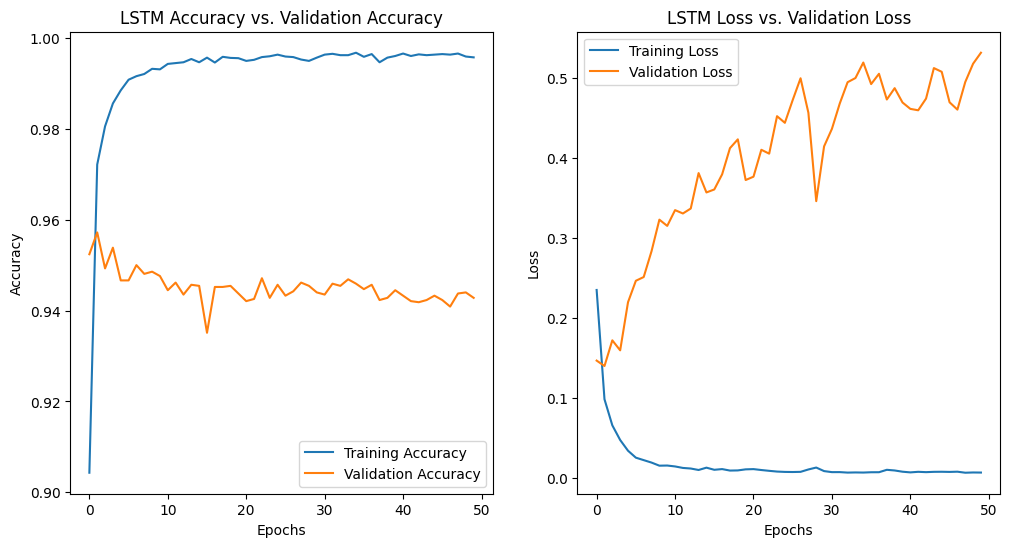

In [ ]:
# Plotting accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['accuracy'], label='Training Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Accuracy vs. Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('LSTM Loss vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# Save model lalu convert ke tfjs
lstm.save('lstm_model.h5')
!tensorflowjs_converter --input_format=keras lstm_model.h5 lstm_model_json

2025-07-15 11:27:52.301270: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752578872.363642   76039 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752578872.379592   76039 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


In [ ]:
# Download model
from google.colab import files
files.download('lstm_model.h5')
files.download('lstm_model_json/group1-shard1of2.bin')
files.download('lstm_model_json/group1-shard2of2.bin')
files.download('lstm_model_json/model.json')
files.download('vocab.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Training Random Forest

In [ ]:
# prompt: train random forest model

from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest Classifier model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Split dataset
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

# Train the model
history_rf = rf_model.fit(x_train, y_train)

# Evaluate the model
rf_accuracy = rf_model.score(x_val, y_val)
print(f"Random Forest Accuracy: {rf_accuracy}")

Random Forest Accuracy: 0.8248438250840942


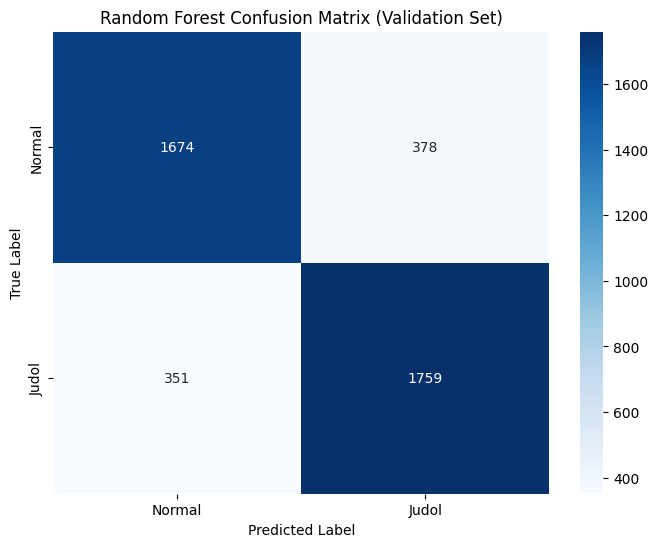

In [ ]:
# prompt: plot random forest model validation confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict on the validation set
y_pred_rf = rf_model.predict(x_val)

# Calculate the confusion matrix
cm_rf = confusion_matrix(y_val, y_pred_rf)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Judol'], yticklabels=['Normal', 'Judol'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Random Forest Confusion Matrix (Validation Set)')
plt.show()


## Training CNN

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D

# Membangun Model CNN
cnn = Sequential()
cnn.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
cnn.add(Conv1D(128, 5, activation='relu'))
cnn.add(GlobalMaxPooling1D())
cnn.add(Dense(64, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(1, activation='sigmoid'))

In [ ]:
# Kompilasi dan Pelatihan Model
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Membagi data menjadi data pelatihan dan validasi (using the already split data)
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

history_cnn = cnn.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))

Epoch 1/10
521/521 [==============================] - 21s 40ms/step - loss: 0.2319 - accuracy: 0.9081 - val_loss: 0.1392 - val_accuracy: 0.9570
Epoch 2/10
521/521 [==============================] - 18s 35ms/step - loss: 0.0824 - accuracy: 0.9751 - val_loss: 0.1476 - val_accuracy: 0.9524
Epoch 3/10
521/521 [==============================] - 18s 35ms/step - loss: 0.0424 - accuracy: 0.9864 - val_loss: 0.2012 - val_accuracy: 0.9541
Epoch 4/10
521/521 [==============================] - 19s 36ms/step - loss: 0.0291 - accuracy: 0.9905 - val_loss: 0.2164 - val_accuracy: 0.9491
Epoch 5/10
521/521 [==============================] - 18s 35ms/step - loss: 0.0174 - accuracy: 0.9930 - val_loss: 0.2626 - val_accuracy: 0.9479
Epoch 6/10
521/521 [==============================] - 19s 36ms/step - loss: 0.0132 - accuracy: 0.9942 - val_loss: 0.3070 - val_accuracy: 0.9476
Epoch 7/10
521/521 [==============================] - 19s 36ms/step - loss: 0.0130 - accuracy: 0.9937 - val_loss: 0.3310 - val_accuracy:

In [ ]:
# Evaluasi Model
loss_cnn, accuracy_cnn = cnn.evaluate(x_val, y_val)
print(f"CNN Loss: {loss_cnn}, CNN Accuracy: {accuracy_cnn}")

131/131 [==============================] - 1s 8ms/step - loss: 0.3818 - accuracy: 0.9378
CNN Loss: 0.3818322718143463, CNN Accuracy: 0.9377703070640564


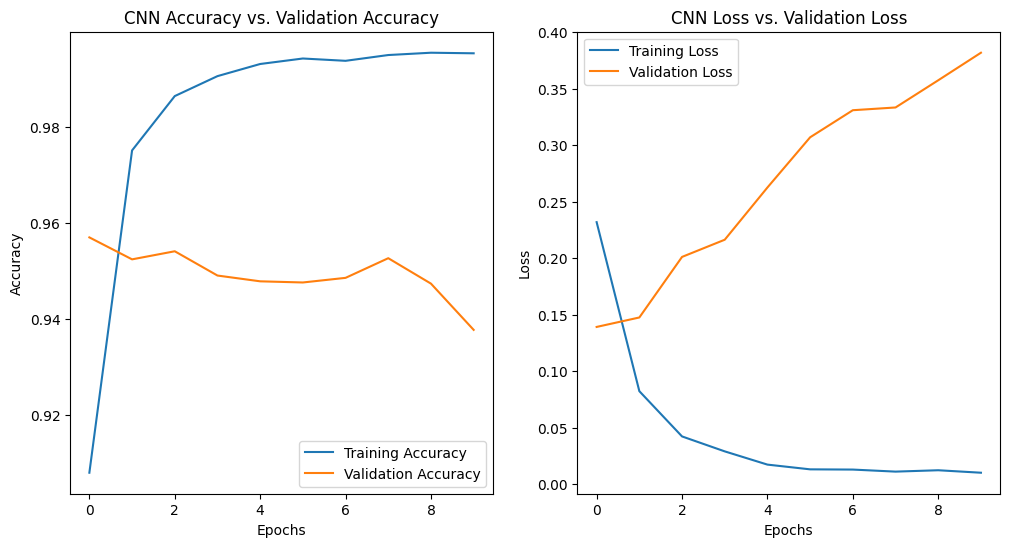

In [ ]:
# Plotting accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Accuracy vs. Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Training Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title('CNN Loss vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()